<a href="https://colab.research.google.com/github/luismangubat/GoogLeNet/blob/main/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Googlenet Model on Distracted Driving Classification

**Instruction**: Run all code blocks until section 3.3

**Paper**: Googlenet for Image Recognition (https://arxiv.org/pdf/1905.03288.
pdf) by Google Researcher Szegedy et al.

This network won the ImageNet Large-Scale Visual Recognition Challenge in 2014 (ILSVRC-2014) where it attain 92.3% classification performance.


**Dataset**: Distracted Driving dataset (https://www.kaggle.com/c/state-farm-distracted-driver-detection/overview/description)

In this Notebnook I will be implemnting Googlenet, and how modified it's architecture

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1 - Pre-processing
The data has already been prepared using the `dataprep.py` 
 - Converted 640x480 images to 120 x 160 x 3 for all images
 - Converted to a numpy array
 - Serialization using Pickle

  This allows for faster training time.

### *1.1: Loading and splitting Dataset*

In [ ]:
import pickle
data_path = "/content/gdrive/MyDrive/data_160_120.pkl"

# Load the dataset from google drive
dataset = pickle.load(open(data_path, "rb"))

# Split up the train and test set 
x_train, x_test, y_train, y_test = dataset["x_train"], dataset["x_test"], dataset["y_train"], dataset["y_test"]

Splitting to get the validation set from the training set (important for hyperparameter tuning).

In [ ]:
val_split = 0.2
val_size = int(x_train.shape[0] * val_split)
x_val = x_train[0:val_size,:,:]
y_val = y_train[0:val_size,:]

x_train = x_train[val_size:,:,:]
y_train = y_train[val_size:,:]

Printing dataset shape:

In [ ]:
print(f"x_train: {x_train.shape},\t y_train: {y_train.shape}")
print(f"  x_val: {x_val.shape},\t   y_val: {y_val.shape}")
print(f" x_test: {x_test.shape},\t  y_test: {y_test.shape}")
print(f" output shape: {y_train[0].shape[0]}")

x_train: (12020, 120, 160, 3),	 y_train: (12020, 10)
  x_val: (3004, 120, 160, 3),	   y_val: (3004, 10)
 x_test: (7400, 120, 160, 3),	  y_test: (7400, 10)
 output shape: 10


Displaying a sample with matplotlib:

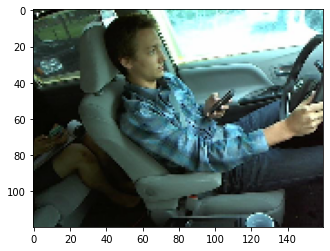

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0][:,:,::-1]) # RGB -> BGR
plt.show()

### *1.2:Generator function*
A generator is used to minimize RAM usage.

In [ ]:
import numpy as np
def generator(X_data, y_data, batch_size):
    """
    This function is a data genetar this used during 
    Which inputs dynamically thus forming a pipeline from the storage to the RAM to load the data as and when it is required.
    Args:
        X_data ([numpy array]): Training Data
        y_data ([numpy array]): Testa Data
        batch_size (int): Number of training example used before updating the network
        augmentations ([type], optional): A list of augmentations.

    Returns:
       Numpy array 
    """

    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0

    while True:

        # normalizing the values:
        X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)]).astype('float32') / 255.
        y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')
        counter += 1
        yield X_batch,y_batch

        # restart counter to yield data in next epoch
        if counter >= number_of_batches:
            counter = 0


            
def generator_predict(X_data, batch_size, augmentations=None):
    """
    A data generator for predicting on a dataset.


    Args:
        X_data ([type]): [description]
        batch_size ([type]): [description]

    """

    # Find the samples per epoch and number of batches
    samples_per_epoch = X_data.shape[0]
    counter = 0

    while counter != samples_per_epoch:

        # Normalize the images
        x_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)]).astype('float32')/255.
        counter += 1

        yield x_batch

## 2 - Creating a GoogLeNet model

In [ ]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten
from keras.models import Model
from keras.regularizers import l2
#from keras.optimizers import SGD
import sys
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers.merge import concatenate
from keras.regularizers import l2
import seaborn as sn


# Created Inception Model
def inception_model(input, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """
    Each block has a special architecture where it extracts simultaneously the input features through four parallel paths.
    The first path uses a convolutional layer with a window size of 1 × 1.
    The second and the third paths, a convolutional layer of size 1 × 1, then applying two expensive 3 × 3 and 5 × 5 convolutions. The 1×1 convolution helps to reduce the number of filter channels. As a result reducing the model complexity.
    The fnal path uses a max-pooling layer to reduce the resolution of the input, and it is followed by a 1 × 1 convolutional layer to reduce the dimension.
    """
    conv_1x1 = Conv2D(filters=filters_1x1, kernel_size=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input)

    conv_3x3_reduce = Conv2D(filters=filters_3x3_reduce, kernel_size=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input)

    conv_3x3 = Conv2D(filters=filters_3x3, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(conv_3x3_reduce)

    conv_5x5_reduce  = Conv2D(filters=filters_5x5_reduce, kernel_size=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input)

    conv_5x5 = Conv2D(filters=filters_5x5, kernel_size=(5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.01))(conv_5x5_reduce)

    maxpool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(input)

    maxpool_proj = Conv2D(filters=filters_pool_proj, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.01))(maxpool)

    inception_output = concatenate([conv_1x1, conv_3x3, conv_5x5, maxpool_proj], axis=3)  # use tf as backend

    return inception_output


In [ ]:
def googLeNet_modified(input_shape, output_shape):

    """
    This function is a modified version of googlenet. It only uses 2 inception blocks. I also removed the 7x7 maxpooling layer. As a result it is a much
    faster neural network and yields better performan.

    Args:
      input_shape (tuple): Input shape for the first layer of the NN
      output_shape (int): Number of classes
    """
    input = Input(shape=(input_shape))

    conv1_7x7_s2 = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input)

    maxpool1_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1_7x7_s2)

    conv2_3x3_reduce = Conv2D(filters=64, kernel_size=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.01))(maxpool1_3x3_s2)

    conv2_3x3 = Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(conv2_3x3_reduce)

    maxpool2_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv2_3x3)

    inception_3a = inception_model(input=maxpool2_3x3_s2, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32)

    inception_3b = inception_model(input=inception_3a, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64)

    averagepool1_3x3_s1 = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), padding='same')(inception_3b)

    drop1 = Dropout(rate=0.04)(averagepool1_3x3_s1)

    flatten = Flatten()

    linear = Dense(units=output_shape, activation='softmax', kernel_regularizer=l2(0.01))(flatten(drop1))
    last = linear


    model = Model(inputs=input, outputs=last)
    
    return model


## 3 - Compiling, training and tuning on Googlenet
Training is done with the generator function created in *section 1.2*.

### *3.1: Creating the model*

In [ ]:
# Creating the model with the shapes of the data
googLeNet_modified = googLeNet_modified(x_train[0].shape, y_train[0].shape[0]) # number of layers indicate ResNet model created

import tensorflow as tf

# Compiling the model with adam optimizer and a learning rate of 0.001
googLeNet_modified.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
googLeNet_modified.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 60, 80, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 30, 40, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 30, 40, 64)   4160        ['max_pooling2d[0][0]']      

### *3.2: Training*

In [ ]:
batch_size = 128

googLeNet_modified.fit(
    generator(x_train, y_train, batch_size),
    epochs=20,
    steps_per_epoch=x_train.shape[0]//batch_size,

    validation_data=generator(x_val, y_val, batch_size),
    validation_steps=x_val.shape[0]//batch_size
)

Epoch 1/15
93/93 [==============================] - 21s 228ms/step - loss: 0.7193 - accuracy: 0.9108 - val_loss: 0.7480 - val_accuracy: 0.9005
Epoch 2/15
93/93 [==============================] - 21s 225ms/step - loss: 0.7071 - accuracy: 0.9159 - val_loss: 0.7706 - val_accuracy: 0.9015
Epoch 3/15
93/93 [==============================] - 21s 225ms/step - loss: 0.7013 - accuracy: 0.9173 - val_loss: 0.7163 - val_accuracy: 0.9181
Epoch 4/15
93/93 [==============================] - 21s 225ms/step - loss: 0.6891 - accuracy: 0.9174 - val_loss: 0.6870 - val_accuracy: 0.9243
Epoch 5/15
93/93 [==============================] - 21s 223ms/step - loss: 0.6789 - accuracy: 0.9254 - val_loss: 0.6698 - val_accuracy: 0.9293
Epoch 6/15
93/93 [==============================] - 21s 224ms/step - loss: 0.6740 - accuracy: 0.9246 - val_loss: 0.6864 - val_accuracy: 0.9161
Epoch 7/15
93/93 [==============================] - 21s 227ms/step - loss: 0.6682 - accuracy: 0.9261 - val_loss: 0.6759 - val_accuracy: 0.9202

### *3.3: Testing*

In [ ]:
# Testing model
googLeNet_modified.evaluate(generator(x_test, y_test, batch_size), steps=x_test.shape[0]//batch_size)

57/57 [==============================] - 5s 79ms/step - loss: 0.6801 - accuracy: 0.9237


[0.6800633668899536, 0.9236568212509155]

Accuracy:  0.9241891891891892
Precision:  0.9277257971631995
Recall:  0.9232709402099035


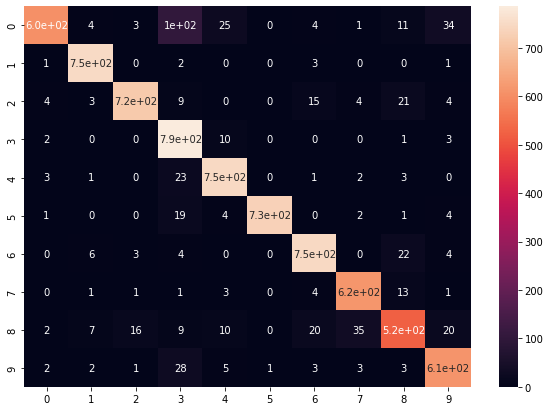

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

pred_modified = np.argmax(googLeNet_modified.predict(generator_predict(x_test, batch_size)), axis=1)

# All the required performance metrics that was stated in the paper
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), pred_modified)
acc = accuracy_score(np.argmax(y_test, axis=1), pred_modified)
prec = precision_score(np.argmax(y_test, axis=1), pred_modified, average='macro' )
recall = recall_score(np.argmax(y_test, axis=1), pred_modified, average='macro')

#Displaying confusion matrix with seaborn and printing out accuracy
plt.figure(figsize = (10,7))
sn.heatmap(conf_mat, annot=True)
print('Accuracy: ', acc)
print('Precision: ', prec)
print('Recall: ', recall)

### *4.2 (Optional): Full Scale GoogleNet Model*
The rest of this section is not needed for my model to run.


In [ ]:
Tdef googLeNet(input_shape, output_shape):
    """
    This function is the full version googlenet which utilizes 9 inception blocks

    Args:
      input_shape (tuple): Input shape for the first layer of the NN
      output_shape (int): Number of classes
    """
    
    input = Input(shape=(input_shape))

    # Convulutional Layer with kernel size 7x7
    conv1_7x7_s2 = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input)

    maxpool1_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1_7x7_s2)

    conv2_3x3_reduce = Conv2D(filters=64, kernel_size=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.01))(maxpool1_3x3_s2)

    conv2_3x3 = Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(conv2_3x3_reduce)

    maxpool2_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv2_3x3)

    inception_3a = inception_model(input=maxpool2_3x3_s2, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32)

    inception_3b = inception_model(input=inception_3a, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64)

    maxpool3_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(inception_3b)

    inception_4a = inception_model(input=maxpool3_3x3_s2, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64)

    inception_4b = inception_model(input=inception_4a, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)

    inception_4c = inception_model(input=inception_4b, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)

    inception_4d = inception_model(input=inception_4c, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool_proj=64)

    inception_4e = inception_model(input=inception_4d, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128)

    maxpool4_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(inception_4e)

    inception_5a = inception_model(input=maxpool4_3x3_s2, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128)

    inception_5b = inception_model(input=inception_5a, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128)

    averagepool1_7x7_s1 = AveragePooling2D(pool_size=(7, 7), strides=(7, 7), padding='same')(inception_5b)

    drop1 = Dropout(rate=0.4)(averagepool1_7x7_s1)

    flatten = Flatten()

    linear = Dense(units=output_shape, activation='softmax', kernel_regularizer=l2(0.01))(flatten(drop1))
    last = linear


    model2 = Model(inputs=input, outputs=last)
    return model2


In [ ]:
# Creating the model with the shapes of the data
google_full =googLeNet(x_train[0].shape, y_train[0].shape[0]) # number of layers indicate ResNet model created

import tensorflow as tf

# Compiling the model with adam optimizer and a learning rate of 0.001
google_full.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
google_full.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 60, 80, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 30, 40, 64)  0           ['conv2d_15[0][0]']              
                                                                                                  
 conv2d_16 (Conv2D)             (None, 30, 40, 64)   4160        ['max_pooling2d_4[0][0]']  

In [ ]:
batch_size = 32

google_full.fit(
    generator(x_train, y_train, batch_size),
    epochs=3,
    steps_per_epoch=x_train.shape[0]//batch_size,

    validation_data=generator(x_val, y_val, batch_size),
    validation_steps=x_val.shape[0]//batch_size
)

Epoch 1/3
375/375 [==============================] - 70s 166ms/step - loss: 7.4695 - accuracy: 0.1080 - val_loss: 2.3020 - val_accuracy: 0.1179
Epoch 2/3
298/375 [======================>.......] - ETA: 11s - loss: 2.3009 - accuracy: 0.1115

KeyboardInterrupt: ignored

In [ ]:
google_full.evaluate(generator(x_test, y_test, batch_size), steps=x_test.shape[0]//batch_size)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve,  precision_score, recall_score,

pred_full = np.argmax(google_full.predict(generator_predict(x_test, batch_size)), axis=1)

conf_mat_full = confusion_matrix(np.argmax(y_test, axis=1), pred_full)
acc_full = accuracy_score(np.argmax(y_test, axis=1), pred_full)

#Displaying confusion matrix
plt.figure(figsize = (10,7))
sn.heatmap(conf_mat_full, annot=True)
print(acc_full)